In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta  # Technical Analysis library
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt


In [3]:
# Download data
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
STOCKS = ['AAPL','TSLA', 'AMZN', 'GOOGL', 'MSFT', 'META','NVDA']

def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df = df.dropna()
        data[ticker] = df
    return data

data = download_data(STOCKS, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Add technical indicators
def add_technical_indicators(df):
    close = df['Close']
    
    # Ensure 'close' is a Series
    if isinstance(close, pd.DataFrame):
        close = close.squeeze()
    
    # Ensure 'close' is 1D
    if len(close.shape) > 1:
        close = close.flatten()
    
    # Compute indicators
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['MA200'] = ta.trend.sma_indicator(close, window=200)
    df['RSI'] = ta.momentum.RSIIndicator(close, window=14).rsi()
    df['MACD'] = ta.trend.MACD(close).macd()
    
    df = df.dropna()
    return df

for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])
    
print(data)    

{'AAPL': Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2010-10-18    9.580286   11.357143   11.392857   11.224643   11.373929   
2010-10-19    9.323905   11.053214   11.206071   10.715000   10.835714   
2010-10-20    9.355240   11.090357   11.223214   10.959643   11.035714   
2010-10-21    9.324811   11.054286   11.240714   10.957143   11.155714   
2010-10-22    9.263054   10.981071   11.072857   10.939286   11.038214   
...                ...         ...         ...         ...         ...   
2020-12-23  128.059891  130.960007  132.429993  130.779999  132.160004   
2020-12-24  129.047531  131.970001  133.460007  131.100006  131.320007   
2020-12-28  133.662994  136.690002  137.339996  133.509995  133.990005   
2020-12-29  131.883301  134.869995  138.789993  134.339996  138.050003   
2020-12-30  130.758789  133.7

In [6]:
TRAIN_TEST_SPLIT = 0.8
for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])

train_data = {}
test_data = {}
for ticker in STOCKS:
    df = data[ticker]
    split_idx = int(len(df) * TRAIN_TEST_SPLIT)
    train_data[ticker] = df[:split_idx]
    test_data[ticker] = df[split_idx:]

In [13]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, window_size=60):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.window_size = window_size
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.shares_held = 0
        self.max_steps = len(self.df) - window_size
        self.action_space = spaces.Discrete(7)
    
        # Observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size, len(self.df.columns)),
            dtype=np.float32
        )

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        frame = self.df.iloc[self.current_step:self.current_step + self.window_size]
        obs = frame.values
        return obs.astype(np.float32)

    def step(self, action):
        
        # Ensure current_price is a scalar float
        current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
        done = False

        # Before executing action
        prev_net_worth = self.net_worth
        shares_traded = 0

        # Execute action
        if action == 1:  # Buy 10%
            amount = self.initial_balance * 0.1
        elif action == 2:  # Buy 50%
            amount = self.initial_balance * 0.5
        elif action == 3:  # Buy 100%
            amount = self.balance
        elif action == 4:  # Sell 10%
            amount = self.shares_held * current_price * 0.1
        elif action == 5:  # Sell 50%
            amount = self.shares_held * current_price * 0.5
        elif action == 6:  # Sell 100%
            amount = self.shares_held * current_price
        else:  # Hold
            amount = 0

        # Execute buy/sell
        if action in [1, 2, 3]:  # Buy actions
            shares_to_buy = int(amount // current_price)
            if shares_to_buy > 0 and self.balance >= shares_to_buy * current_price:
                self.balance -= shares_to_buy * current_price
                self.shares_held += shares_to_buy
                shares_traded = shares_to_buy
        elif action in [4, 5, 6]:  # Sell actions
            shares_to_sell = int(amount // current_price)
            if shares_to_sell > 0 and self.shares_held >= shares_to_sell:
                self.balance += shares_to_sell * current_price
                self.shares_held -= shares_to_sell
                shares_traded = shares_to_sell

        # Move to next timestep
        self.current_step += 1

        # Update net worth
        self.net_worth = self.balance + self.shares_held * current_price

        # Calculate reward
        reward = self.net_worth - prev_net_worth

        # Transaction cost (e.g., 0.1% per trade)
        transaction_cost = 0.001 * current_price * shares_traded
        reward -= transaction_cost

        # Normalize reward
        reward /= self.initial_balance


        if self.current_step >= self.max_steps:
            done = True

        obs = self._next_observation()
        return obs, reward, done, {}


    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

In [21]:
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layers=2, hidden_dim=64, output_dim=3, dropout_rate=0.2):
        super(DeepQNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)    


In [16]:
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_dim=64, learning_rate=1e-3, gamma=0.95, device='cuda',epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.1, 
                 batch_size=64, memory_size=100000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.device = torch.device(device)
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-Network and Target Network
        self.q_network = DeepQNet(input_dim=state_size, hidden_dim=hidden_dim, output_dim=action_size).to(self.device)
        self.target_network = DeepQNet(input_dim=state_size, hidden_dim=hidden_dim, output_dim=action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay Memory
        self.memory = deque(maxlen=100000)

        # Exploration parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def remember(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            act_values = self.q_network(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        minibatch = random.sample(self.memory, batch_size)
        states = torch.stack([s[0] for s in minibatch]).to(self.device)
        actions = torch.LongTensor([s[1] for s in minibatch]).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor([s[2] for s in minibatch]).unsqueeze(1).to(self.device)
        next_states = torch.stack([s[3] for s in minibatch]).to(self.device)
        dones = torch.FloatTensor([s[4] for s in minibatch]).unsqueeze(1).to(self.device)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

        # Current Q values
        q_values = self.q_network(states).gather(1, actions)

        # Double DQN Target Q values
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_network(next_states).gather(1, next_actions)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [17]:
def train_dqn_agent(env, agent, num_episodes=100, batch_size=64, target_update_freq=10):
    rewards_history = []
    losses = []

    for e in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Flatten the observation
            state_flat = state.flatten()
            # Select action
            action = agent.act(state_flat)
            # Execute action
            next_state, reward, done, _ = env.step(action)
            next_state_flat = next_state.flatten()
            # Store experience
            agent.remember(state_flat, action, reward, next_state_flat, done)
            # Update state
            state = next_state
            total_reward += reward
            # Replay and train
            loss = agent.replay(batch_size)
            if loss is not None:
                losses.append(loss)

        rewards_history.append(total_reward)
        print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

        # Update target network
        if e % target_update_freq == 0:
            agent.update_target_network()

    return rewards_history, losses


In [25]:
def plot_training_metrics(rewards, losses):
    plt.figure(figsize=(12,5))

    # Plot Rewards
    plt.subplot(1,2,1)
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Rewards')
    plt.legend()

    # Plot Losses
    plt.subplot(1,2,2)
    plt.plot(losses, label='Loss per Training Step')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('DQN Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [27]:
def test_dqn_agent(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    agent.epsilon = 0.0  # No exploration during testing
    net_worths = []
    actions = []
    prices = []
    steps = []
    balances = []
    shares_helds = []

    while not done:
        state_flat = state.flatten()
        action = agent.act(state_flat)
        next_state, reward, done, _ = env.step(action)
        
        # Record data
        net_worths.append(env.net_worth)
        actions.append(action)
        current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])
        prices.append(current_price)
        steps.append(env.current_step)
        balances.append(env.balance)
        shares_helds.append(env.shares_held)

        state = next_state
        total_reward += reward

    print(f"Test completed. Total Reward: {total_reward}")
    return net_worths, actions, prices, steps, balances, shares_helds


In [29]:
def plot_cumulative_returns(net_worths, env):
    initial_balance = env.initial_balance
    agent_returns = np.array(net_worths) / initial_balance - 1
    
    # Buy-and-hold returns
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_prices = env.df['Close'].values[env.window_size - 1:]
    buy_and_hold_returns = final_prices / initial_price - 1
    
    # Ensure the lengths match
    min_length = min(len(agent_returns), len(buy_and_hold_returns))
    agent_returns = agent_returns[:min_length]
    buy_and_hold_returns = buy_and_hold_returns[:min_length]
    
    plt.figure(figsize=(12,6))
    plt.plot(agent_returns, label='Agent Strategy')
    plt.plot(buy_and_hold_returns, label='Buy and Hold Strategy')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.show()


def plot_portfolio_components(net_worths, balances, equity_values):
    plt.figure(figsize=(12,6))
    plt.plot(balances, label='Cash Balance')
    plt.plot(equity_values, label='Equity Value')
    plt.plot(net_worths, label='Total Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components Over Time')
    plt.legend()
    plt.show()


def plot_test_performance(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()
    
    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    
    # Define action categories based on the new action space
    buy_actions = [1, 2, 3]
    sell_actions = [4, 5, 6]
    hold_actions = [0]
    
    # Map actions to percentages for labeling
    action_labels = {
        1: 'Buy 10%',
        2: 'Buy 50%',
        3: 'Buy 100%',
        4: 'Sell 10%',
        5: 'Sell 50%',
        6: 'Sell 100%',
    }
    
    # Plot buy actions
    for action in buy_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='^', label=action_labels[action])
    
    # Plot sell actions
    for action in sell_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='v', label=action_labels[action])
    
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_buy_and_hold(env):
    initial_balance = env.initial_balance
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_price = float(env.df.iloc[-1]['Close'])
    shares = initial_balance // initial_price
    remaining_balance = initial_balance - shares * initial_price
    final_net_worth = remaining_balance + shares * final_price
    return final_net_worth


def compute_performance_metrics(net_worths):
    net_worths = np.array(net_worths)
    returns = np.diff(net_worths) / net_worths[:-1]
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0]
    annualized_return = total_return * (252 / len(net_worths))  # Assuming daily data

    # Sharpe Ratio
    risk_free_rate = 0.0  # Assuming zero risk-free rate
    if np.std(returns) != 0:
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0  # Avoid division by zero

    # Maximum Drawdown
    cumulative_returns = net_worths / net_worths[0]
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (running_max - cumulative_returns) / running_max
    max_drawdown = np.max(drawdowns)

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")



Training DQN agent for AAPL


C:\Users\yang1\AppData\Local\Temp\ipykernel_14864\4064166094.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])


Episode 1/10, Total Reward: 0.9466685583658412, Epsilon: 0.01
Episode 2/10, Total Reward: 0.5718697049870691, Epsilon: 0.01
Episode 3/10, Total Reward: 0.21456628601183905, Epsilon: 0.01
Episode 4/10, Total Reward: 0.5628135761891367, Epsilon: 0.01
Episode 5/10, Total Reward: 0.2513974857652185, Epsilon: 0.01
Episode 6/10, Total Reward: 0.27225716628995983, Epsilon: 0.01
Episode 7/10, Total Reward: 0.6573557544093132, Epsilon: 0.01
Episode 8/10, Total Reward: 0.3376288105539224, Epsilon: 0.01
Episode 9/10, Total Reward: 0.9682082087477966, Epsilon: 0.01
Episode 10/10, Total Reward: 0.41167162940609925, Epsilon: 0.01
Trained DQN agent for AAPL saved as dqn_trading_agent_AAPL.pt


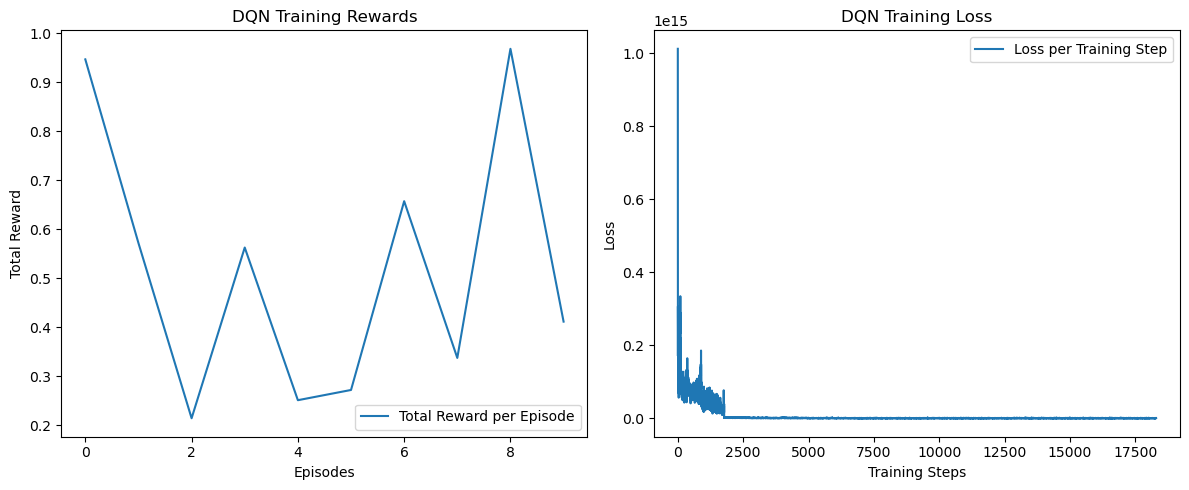

C:\Users\yang1\AppData\Local\Temp\ipykernel_14864\2394355548.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])


Test completed. Total Reward: 1.8183453751477063


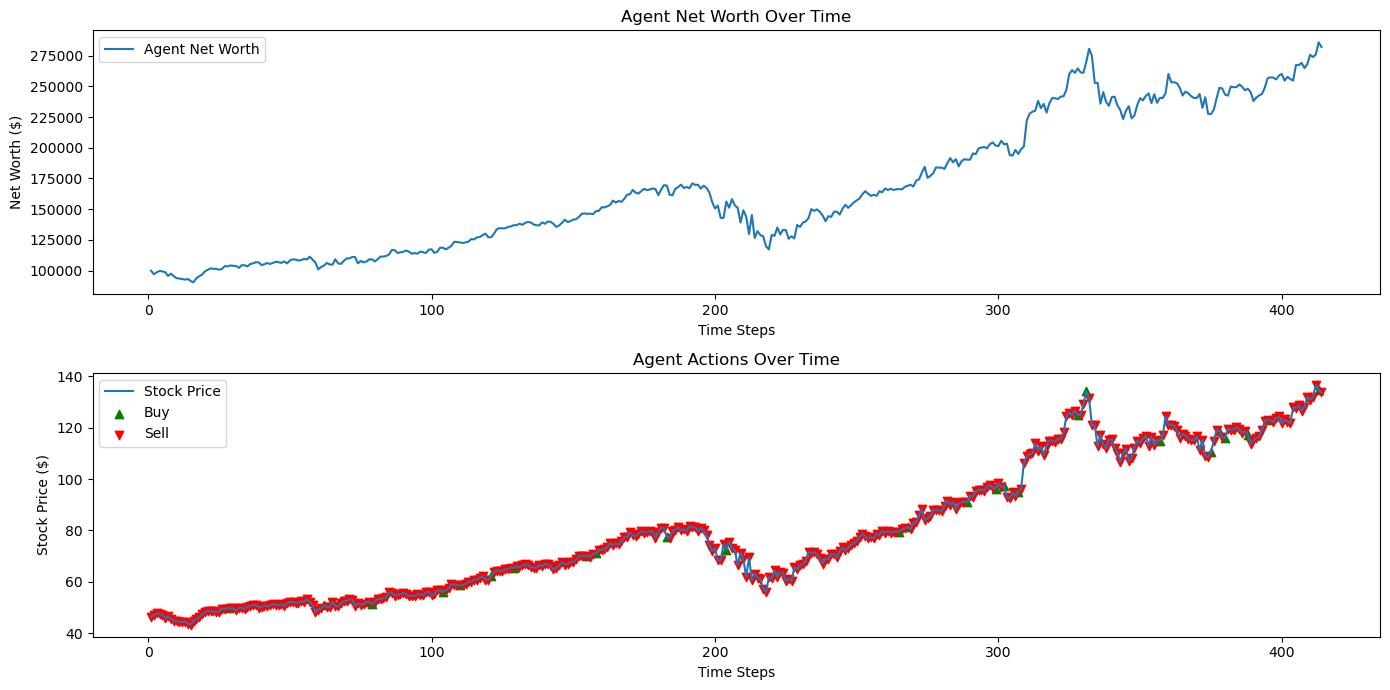

Total Return: 181.93%
Annualized Return: 110.74%
Sharpe Ratio: 1.81
Maximum Drawdown: 57.14%


C:\Users\yang1\AppData\Local\Temp\ipykernel_14864\2367254690.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(env.df.iloc[env.window_size - 1]['Close'])


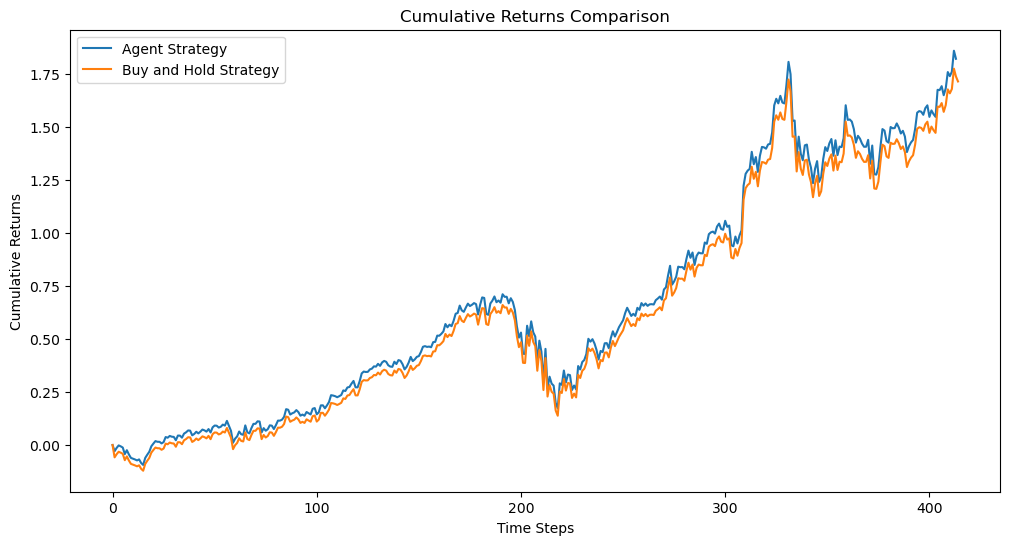

C:\Users\yang1\AppData\Local\Temp\ipykernel_14864\2367254690.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[current_step - 1]['Close'])


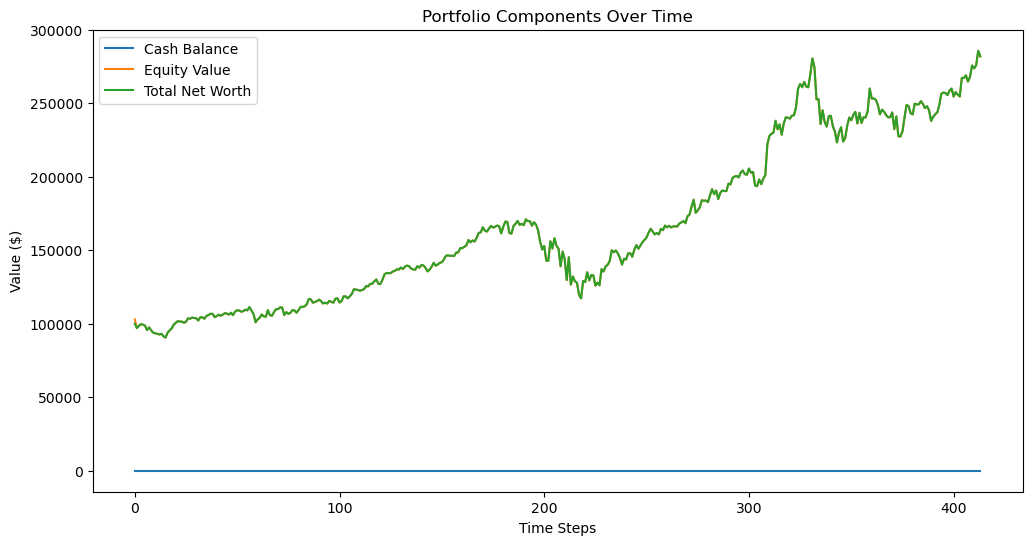


Training DQN agent for TSLA
Episode 1/10, Total Reward: 2.6115589288709353, Epsilon: 0.01
Episode 2/10, Total Reward: -0.07253523357174874, Epsilon: 0.01
Episode 3/10, Total Reward: -0.011064522501411383, Epsilon: 0.01
Episode 4/10, Total Reward: -0.01978106681756733, Epsilon: 0.01
Episode 5/10, Total Reward: -0.019507613564528216, Epsilon: 0.01
Episode 6/10, Total Reward: -0.06297252893581859, Epsilon: 0.01
Episode 7/10, Total Reward: -0.020414166135303977, Epsilon: 0.01
Episode 8/10, Total Reward: -0.004502664827580436, Epsilon: 0.01
Episode 9/10, Total Reward: 0.08650761055116411, Epsilon: 0.01
Episode 10/10, Total Reward: 0.04890838535398483, Epsilon: 0.01
Trained DQN agent for TSLA saved as dqn_trading_agent_TSLA.pt


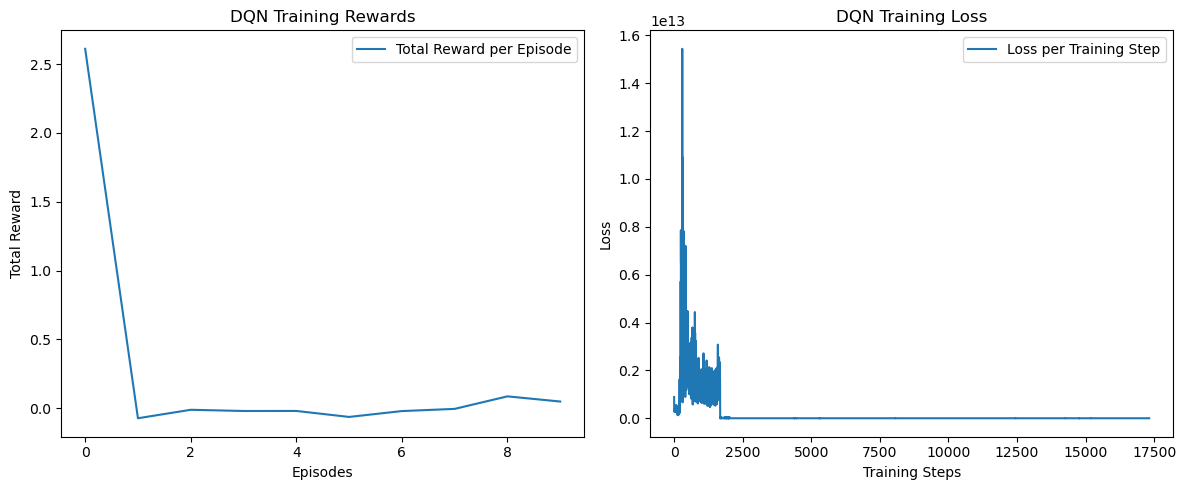

Test completed. Total Reward: 0.0


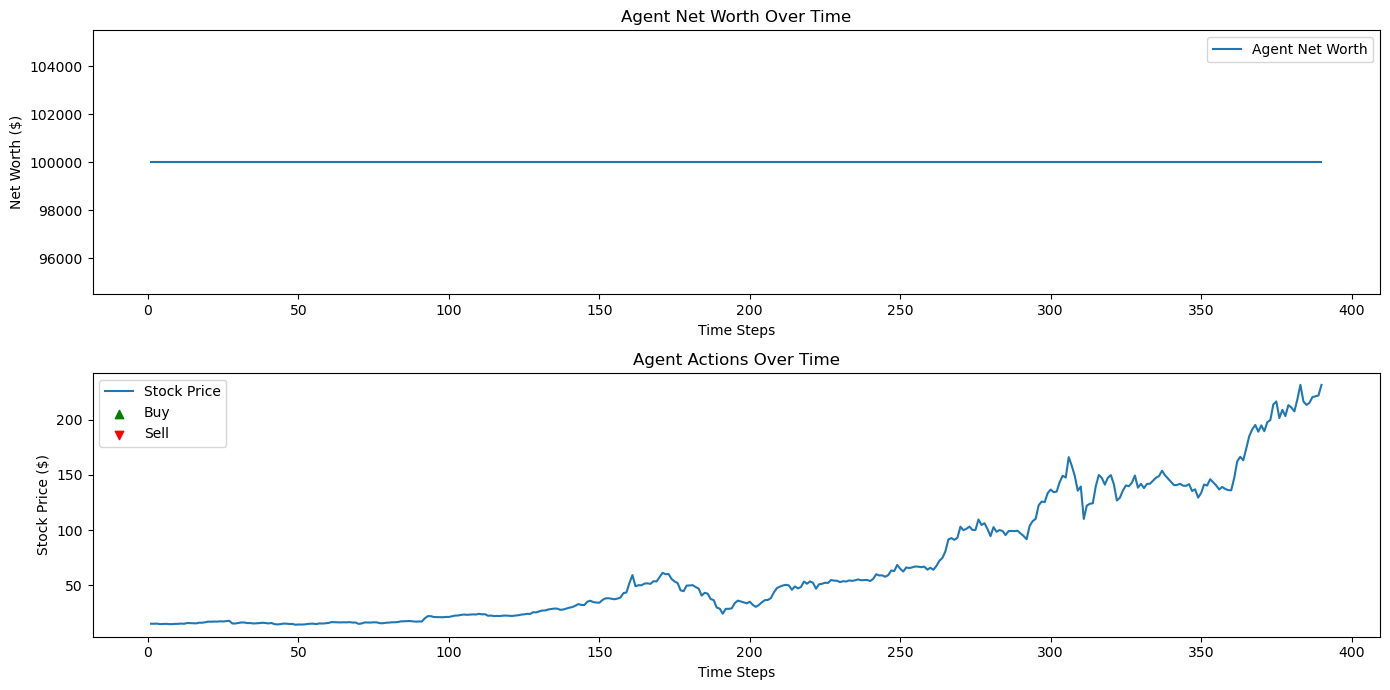

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: nan
Maximum Drawdown: 0.00%


C:\Users\yang1\AppData\Local\Temp\ipykernel_14864\2367254690.py:81: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)


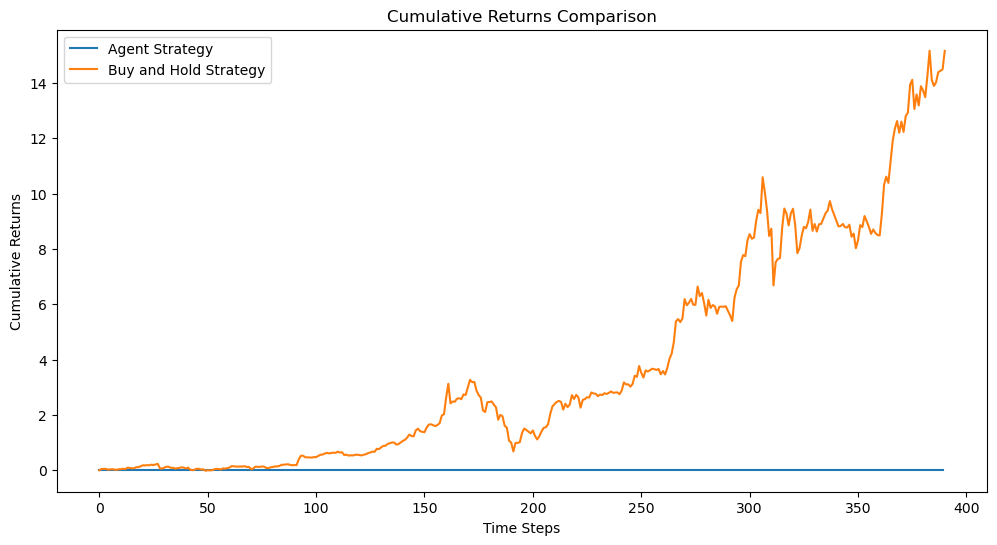

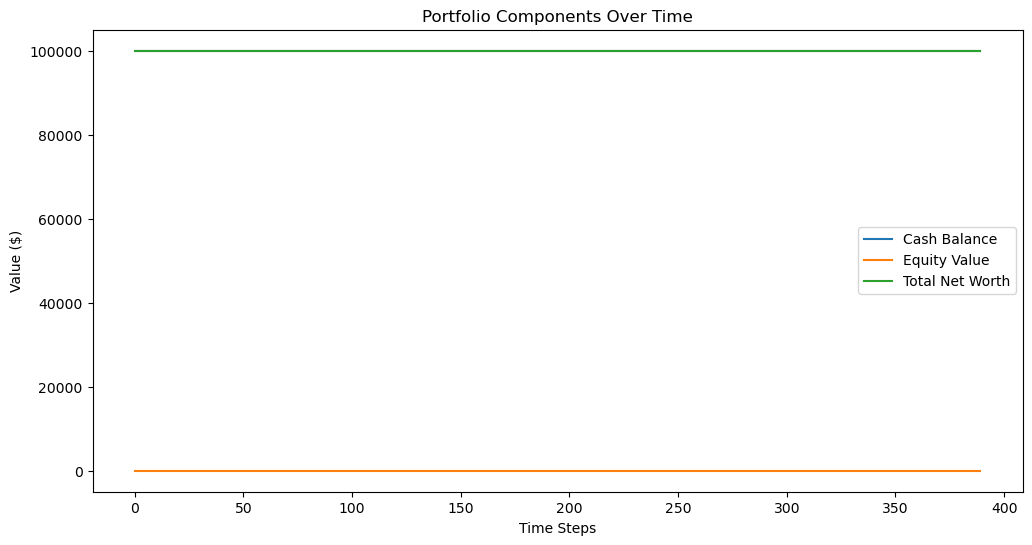


Training DQN agent for AMZN
Episode 1/10, Total Reward: 5.356076377563908, Epsilon: 0.01
Episode 2/10, Total Reward: 5.670966550479022, Epsilon: 0.01
Episode 3/10, Total Reward: 5.0578449743807, Epsilon: 0.01
Episode 4/10, Total Reward: 5.606447074378119, Epsilon: 0.01
Episode 5/10, Total Reward: 6.015355464435319, Epsilon: 0.01
Episode 6/10, Total Reward: 6.099074363195037, Epsilon: 0.01
Episode 7/10, Total Reward: 4.957272250261151, Epsilon: 0.01
Episode 8/10, Total Reward: 5.67975496358237, Epsilon: 0.01
Episode 9/10, Total Reward: 5.2627686884947025, Epsilon: 0.01
Episode 10/10, Total Reward: 5.469723909461936, Epsilon: 0.01
Trained DQN agent for AMZN saved as dqn_trading_agent_AMZN.pt


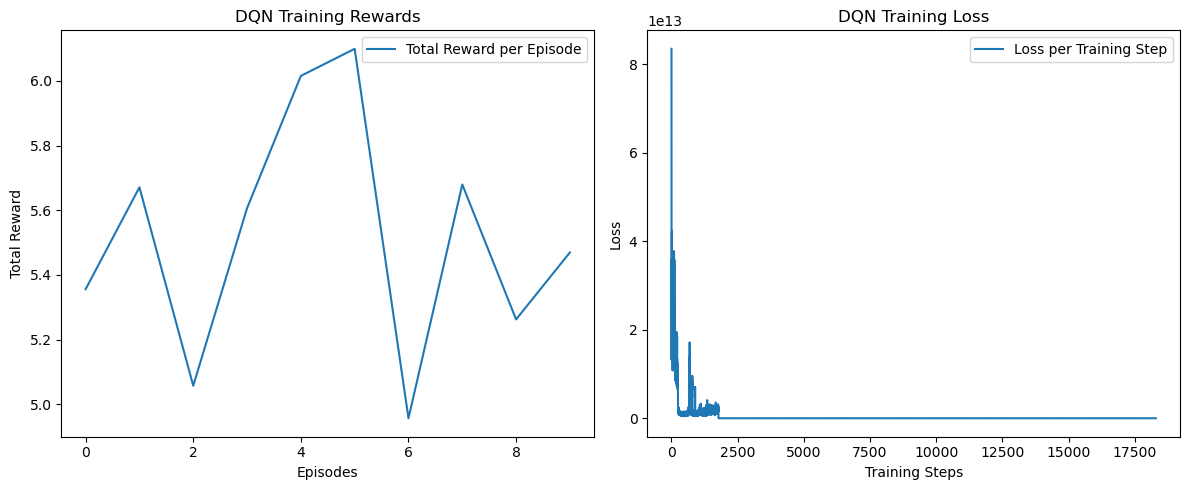

Test completed. Total Reward: 0.7885837040645602


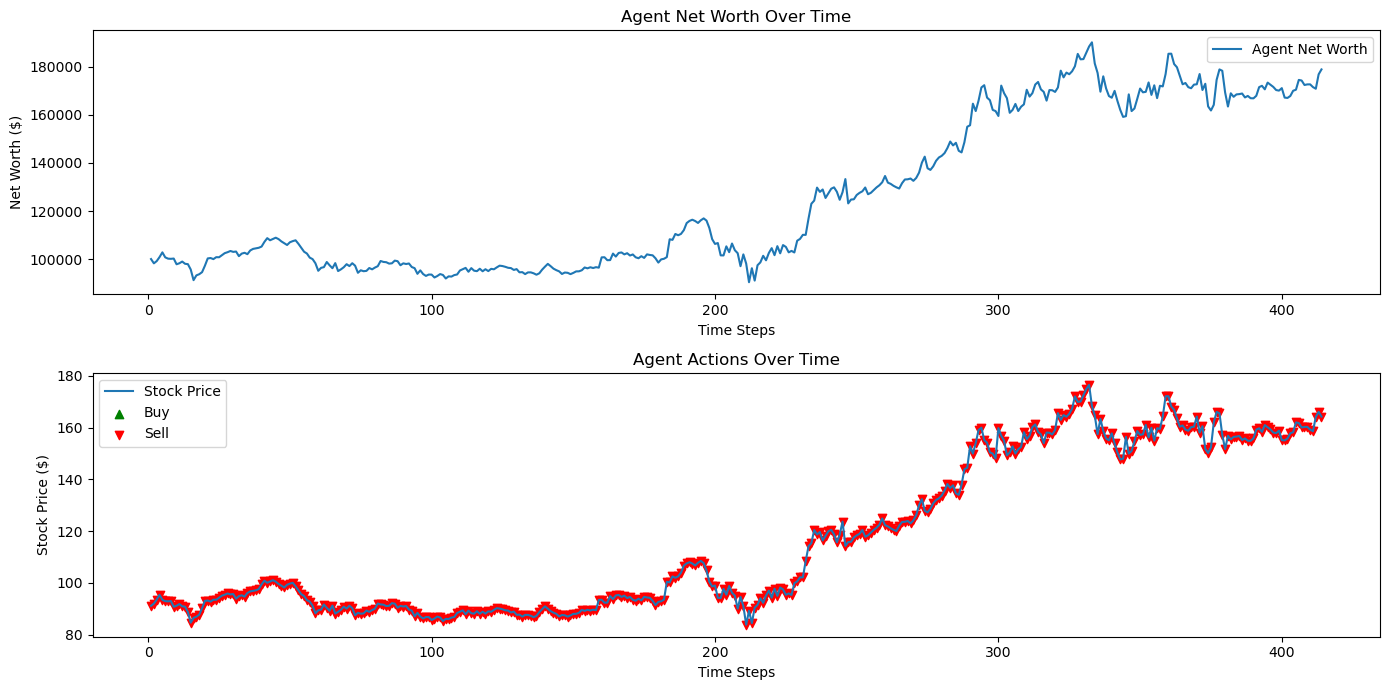

Total Return: 78.96%
Annualized Return: 48.06%
Sharpe Ratio: 1.25
Maximum Drawdown: 31.05%


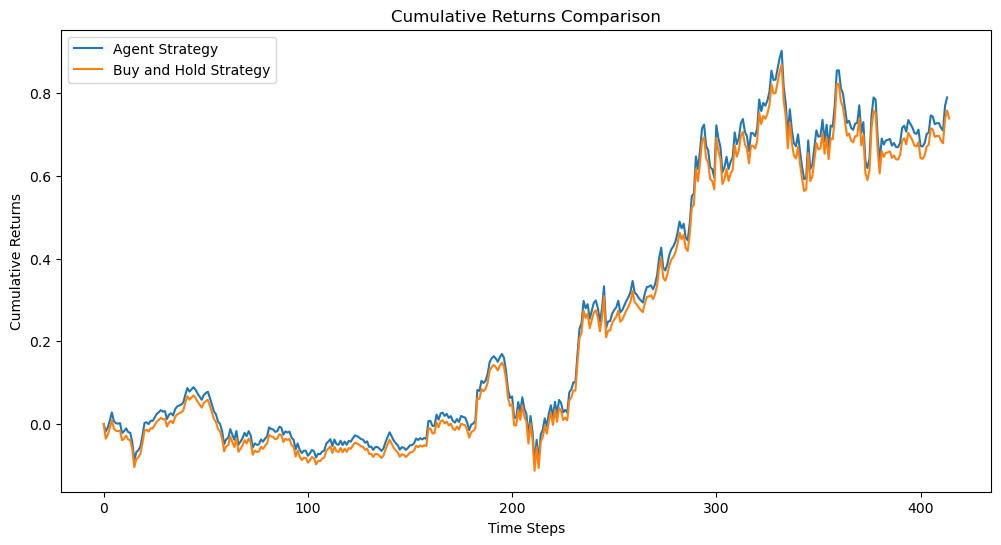

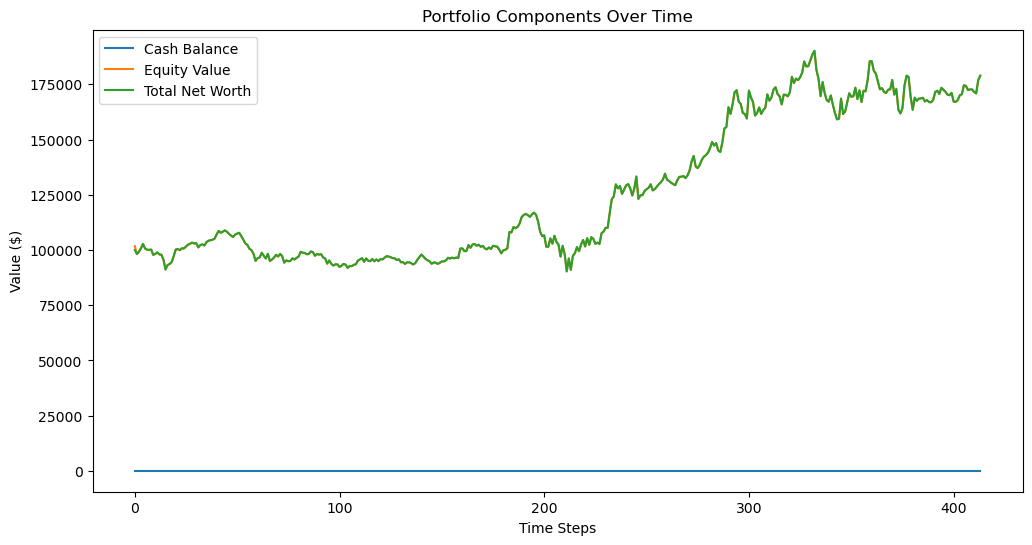


Training DQN agent for GOOGL
Episode 1/10, Total Reward: 0.22438167783328994, Epsilon: 0.01
Episode 2/10, Total Reward: -0.003463735302133566, Epsilon: 0.01
Episode 3/10, Total Reward: 0.010114720981063845, Epsilon: 0.01
Episode 4/10, Total Reward: -0.0015996991506004347, Epsilon: 0.01
Episode 5/10, Total Reward: 0.006780300361137397, Epsilon: 0.01
Episode 6/10, Total Reward: 0.013251675195827478, Epsilon: 0.01
Episode 7/10, Total Reward: 0.002153184674758912, Epsilon: 0.01
Episode 8/10, Total Reward: -0.014440823758392353, Epsilon: 0.01
Episode 9/10, Total Reward: 0.016150080805587788, Epsilon: 0.01
Episode 10/10, Total Reward: -0.00774944360981943, Epsilon: 0.01
Trained DQN agent for GOOGL saved as dqn_trading_agent_GOOGL.pt


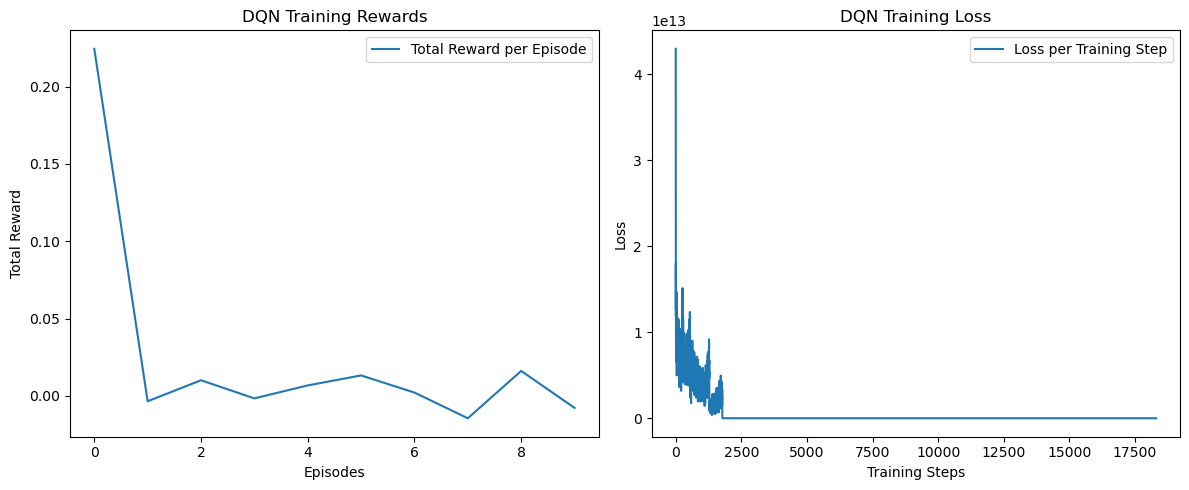

Test completed. Total Reward: 0.0


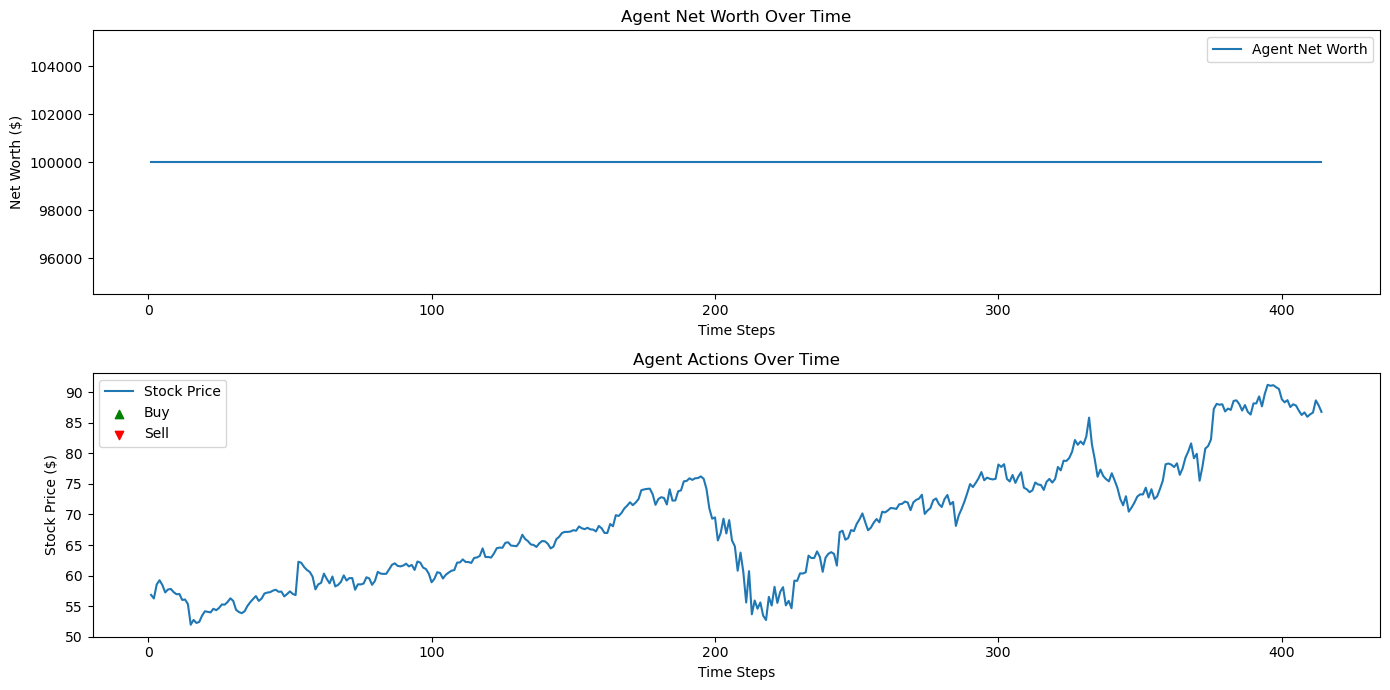

Total Return: 0.00%
Annualized Return: 0.00%
Sharpe Ratio: nan
Maximum Drawdown: 0.00%


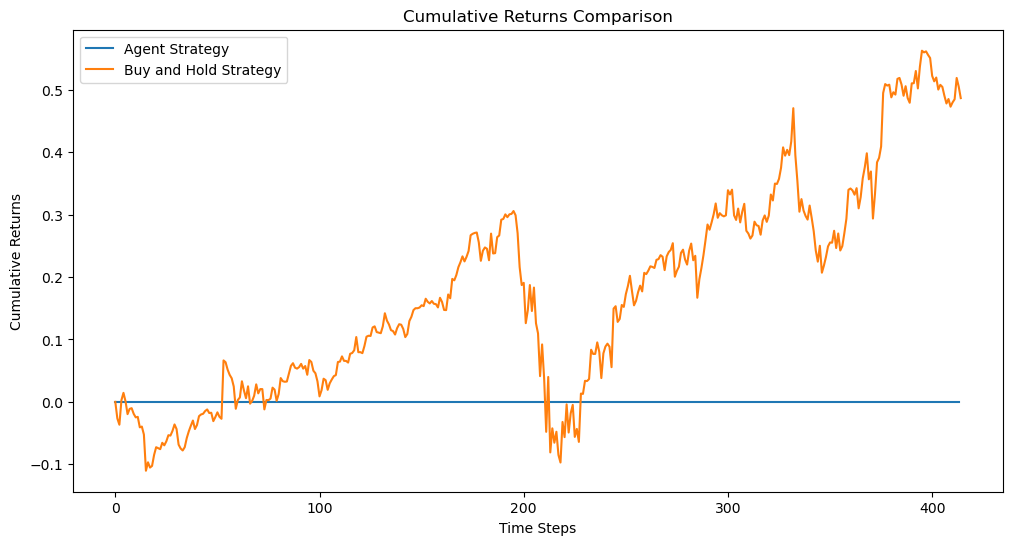

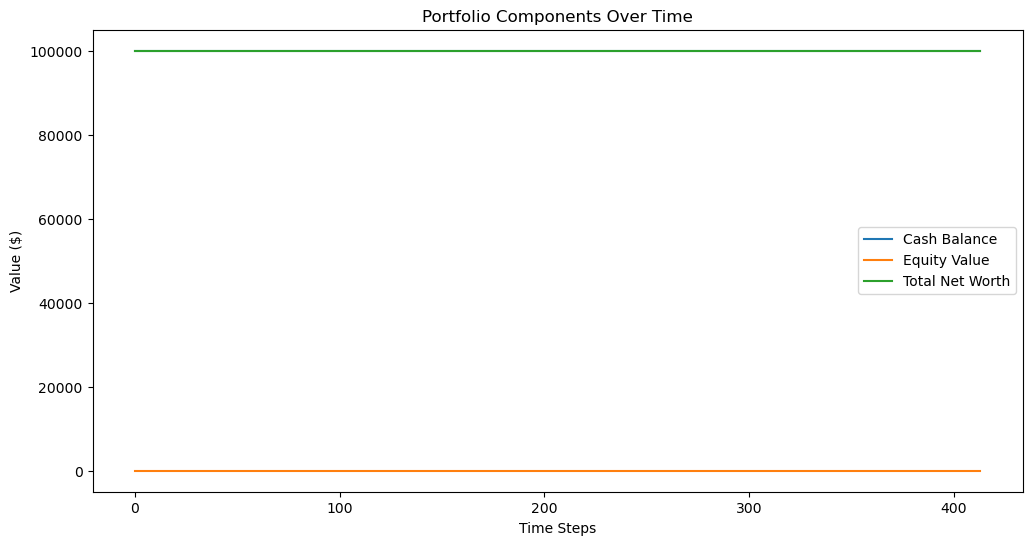


Training DQN agent for MSFT
Episode 1/10, Total Reward: 0.2239935196111495, Epsilon: 0.01
Episode 2/10, Total Reward: 0.013415635273990636, Epsilon: 0.01


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    num_episodes = 10  # Adjust as needed
    batch_size = 64
    target_update_freq = 10

    for ticker in STOCKS:
        print(f"\nTraining DQN agent for {ticker}")
        # Prepare environment
        df_train = train_data[ticker]
        env = TradingEnv(df_train)

        # Determine state and action sizes
        state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
        action_size = env.action_space.n

        # Initialize agent
        agent = DQNAgent(state_size=state_size, action_size=action_size, device='cpu')

        # Train agent
        rewards_history, losses = train_dqn_agent(env, agent, num_episodes=num_episodes, batch_size=batch_size, target_update_freq=target_update_freq)

        # Save the trained model
        torch.save(agent.q_network.state_dict(), f'dqn_trading_agent_{ticker}.pt')
        print(f"Trained DQN agent for {ticker} saved as dqn_trading_agent_{ticker}.pt")

        # Plot training metrics
        plot_training_metrics(rewards_history, losses)

         # Testing the agent on test data
        print(f"\nTesting DQN agent for {ticker}")
        df_test = test_data[ticker]
        env_test = TradingEnv(df_test)
        agent.q_network.eval()
        net_worths, actions, prices, steps, balances, shares_helds = test_dqn_agent(env_test, agent)

        # Compute equity values
        equity_values = [shares_helds[i] * prices[i] for i in range(len(shares_helds))]

        # Plot test performance
        plot_test_performance(net_worths, actions, prices, steps)
        compute_performance_metrics(net_worths)
        plot_cumulative_returns(net_worths, env_test)
        plot_portfolio_components(net_worths, balances, equity_values)


In [ ]:
if __name__ == "__main__":
    # Load the test data
    ticker = 'AAPL'
    df_test = test_data[ticker]
    env_test = TradingEnv(df_test)
    
    # Initialize agent
    state_size = env_test.observation_space.shape[0] * env_test.observation_space.shape[1]
    action_size = env_test.action_space.n
    
    agent = DQNAgent(state_size=state_size, action_size=action_size, device='cpu')
    # Load the trained model
    agent.q_network.load_state_dict(torch.load(f'dqn_trading_agent_{ticker}.pt'))
    agent.q_network.eval()
    
    # Test the agent
    net_worths, actions, prices, steps = test_dqn_agent(env_test, agent)
    
    # Plot the performance
    plot_test_performance(net_worths, actions, prices, steps)
    
    # Compute performance metrics
    compute_performance_metrics(net_worths)
    
    # Compute buy-and-hold net worth
    buy_and_hold_net_worth = compute_buy_and_hold(env_test)
    print(f"Buy and Hold Net Worth: ${buy_and_hold_net_worth:.2f}")
    print(f"Agent's Final Net Worth: ${net_worths[-1]:.2f}")

NameError: name 'test_data' is not defined